#EECS 442 PS5: Scene Recognition

Calvin Tran, cktran




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm
  
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  1.9.0+cu111
Torchvision Version:  0.10.0+cu111
Using the GPU!


# Problem 5.1 Scene Recognition with VGG

You will build and train a convolutional neural network for scene recognition, i.e., classifying images into different scenes. You will need to:
1. Construct dataloaders for train/val/test datasets
2. Build MiniVGG and MiniVGG-BN (MiniVGG with batch-normalization layers)
3. Train MiniVGG and MiniVGG-BN, compare their training progresses and their final top-1 and top-5 accuracies.
4. (Optional) Increase the size of the network by adding more layers and check whether top-1 and top-5 accuracies will improve.

## Step 0: Downloading the dataset.



In [ ]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab. 
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

--2021-10-08 23:30:32--  http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534628730 (510M) [application/zip]
Saving to: ‘data_miniplaces_modified.zip’

data_miniplaces_mod 100%[===================>] 509.86M  5.56MB/s    in 1m 47s  

2021-10-08 23:32:19 (4.76 MB/s) - ‘data_miniplaces_modified.zip’ saved [534628730/534628730]



In [ ]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient. 
!unzip -q data_miniplaces_modified.zip

## Step 1: Build dataloaders for train, val, and test

In [ ]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    """
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.
    """

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    ###########################################################################
    # TODO: Step 1: Build transformations for the dataset.                    #
    # You need to construct a data transformation that does three             #
    # preprocessing steps in order:                                           #
    # I. Resize the image to input_size using transforms.Resize               #
    # II. Convert the image to PyTorch tensor using transforms.ToTensor       #
    # III. Normalize the images with the provided mean and std parameters     #
    # using transforms.Normalize. These parameters are accumulated from a     #
    # large number of training samples.                                       #
    # You can use transforms.Compose to combine the above three               #
    # transformations. Store the combined transforms in the variable          #
    # 'composed_transform'.                                                   #
    ###########################################################################
    composed_transform = transforms.Compose([
                        transforms.Resize(input_size),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                        ])
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    # We write the remaining part of the dataloader for you.  
    # You are encouraged to go through this.

    ###########################################################################
    # Step 2: Build dataloaders.                                              #
    # I. We use torch.datasets.ImageFolder with the provided data_dir and the #
    # data transfomations you created in step 1 to construct pytorch datasets #
    # for training, validation, and testing.                                  #
    # II. Then we use torch.utils.data.DataLoader to build dataloaders with   #
    # the constructed pytorch datasets. You need to enable shuffling for      #
    # the training set. Set num_workers=2 to speed up dataloading.            #
    # III. Finally, we put the dataloaders into a dictionary.                 #
    ###########################################################################

    # Create train/val/test datasets
    data_transforms = {
        'train': composed_transform,
        'val': composed_transform,
        'test': composed_transform
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}

    return dataloaders_dict

In [ ]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 90000
# of validation samples 10000
# of test samples 10000


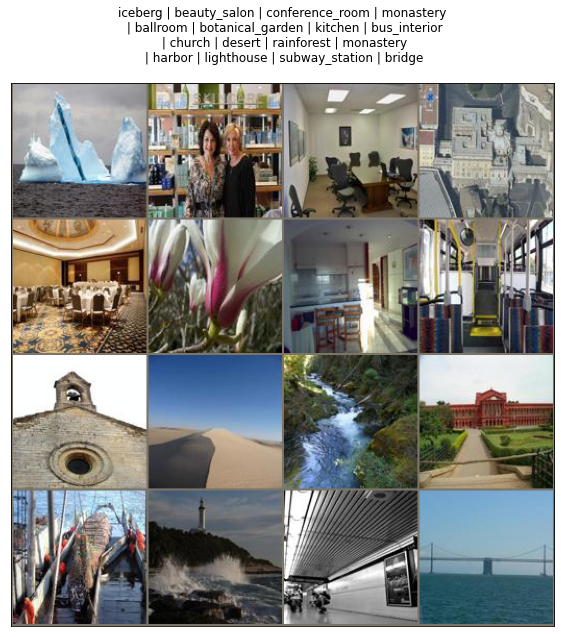

In [ ]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(10, 10)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

## Step 2. Build MiniVGG and MiniVGG-BN

Please follow the instructions to build the two neural networks with architectures shown below.

__MiniVGG architecture__

![alt text](https://drive.google.com/uc?id=1RF3CjEsHBpRjubqwgBUxIEv54gpDjt95)

__MiniVGG-BN architecure__

![alt text](https://drive.google.com/uc?id=1HR5N2V-5RVT1u_bVzyCvhPJZ7PSnYm6x)


In [ ]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    """
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    """

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [ ]:
# Network configurations for all layers before the final fully-connected layers. 
# "M" corresponds to maxpooling layer, integers correspond to number of output 
# channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):
    """
    Return a nn.Sequential object containing all layers to get the features 
    using the CNN. (That is, before the Average pooling layer in the two 
    pictures above). 

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer 
                  should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction
                layers. For use of torch.nn.Sequential, please refer to 
                PyTorch documentation.
    """
    ###########################################################################
    # TODO: Construct the neural net architecture from cfg. You should use    #
    # nn.Sequential().                                                        #
    ###########################################################################
    kernel = (3, 3)
    stride = (1, 1)
    pad = (1, 1)

    layers = []

    in_chan = 3

    for i in range(len(cfg)):
      # print("layer =", cfg[i])
      if cfg[i] == 'M':
        layers += [nn.MaxPool2d(2, 2, 0, 1, False)]
      else:
        layers += [nn.Conv2d(in_chan, cfg[i], kernel, stride, pad)]
        if batch_norm:
          layers += [nn.BatchNorm2d(cfg[i], 1e-05, 0.1, True, True)]
        layers += [nn.ReLU(True)]
        in_chan = cfg[i]
    
    features = nn.Sequential(*layers)
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        #######################################################################
        # TODO: Construct the final FC layers using nn.Sequential.            #
        # Note: The average pooling layer has been defined by us above.       #
        #######################################################################        
        self.classifier = nn.Sequential(
                                         nn.Linear(3200, 512, True),
                                         nn.ReLU(True),
                                         nn.Dropout(0.3, False),
                                         nn.Linear(512, 256, True),
                                         nn.ReLU(True),
                                         nn.Dropout(0.3, False),
                                         nn.Linear(256, 100, True)
        )
        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################

        if init_weights:
            self._initialize_weights()

    def forward(self, x): 
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with 
# the one given in the instructions above. 
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=Tru

## Step 3: Build training/validation loops

You will write a function for training and validating the network. 

In [ ]:
def make_optimizer(model):
    """
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    """
    ###########################################################################
    # TODO: Create a SGD optimizer with learning rate=1e-2 and momentum=0.9.  #
    # HINT: Check out optim.SGD() and initialize it with the appropriate      #
    # parameters. We have imported torch.optim as optim for you above.        #
    ###########################################################################
    optimizer = optim.SGD(model.parameters(), 1e-2, 0.9)
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return optimizer

def get_loss():
    """
    Returns:
        criterion: pytorch loss. 
    """
    ###########################################################################
    # TODO: Create an instance of the cross entropy loss. This code           #
    # should be a one-liner.                                                  #
    ###########################################################################
    criterion = nn.CrossEntropyLoss()
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return criterion

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    """
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    """

    val_acc_history = []
    tr_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                ###############################################################
                # TODO:                                                       #
                # Please read all the inputs carefully!                       #
                # For "train" phase:                                          #
                # (i)   Compute the outputs using the model                   #
                #       Also, use the  outputs to calculate the class         #
                #       predicted by the model,                               #
                #       Store the predicted class in 'preds'                  #
                #       (Think: argmax of outputs across a dimension)         #
                #       torch.max() might help!                               #
                # (ii)  Use criterion to store the loss in 'loss'             # 
                # (iii) Update the model parameters                           #
                # Notes:                                                      #
                # - Don't forget to zero the gradients before beginning the   #
                # loop!                                                       #
                # - "val" phase is the same as train, but without backprop    #
                # - Compute the outputs (Same as "train", calculate 'preds'   #
                # too),                                                       #
                # - Calculate the loss and store it in 'loss'                 #
                ###############################################################
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                  loss.backward()
                  optimizer.step()

                ###############################################################
                #                         END OF YOUR CODE                    #
                ###############################################################

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # =========================================================== #
                # IMPORTANT:
                # Losing your connection to colab will lead to loss of trained 
                # weights.
                # You should download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to 
                # train the neural networks again.
                # =========================================================== #
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

## Step 4. Train MiniVGG and MiniVGG-BN

In [ ]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training 
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloaders and criterion function
input_size = 64
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [ ]:
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')

Epoch 0/19
----------


  0%|          | 0/704 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 704/704 [01:46<00:00,  6.64it/s]


train Loss: 4.4919 Acc: 0.0186


100%|██████████| 79/79 [00:10<00:00,  7.81it/s]


val Loss: 4.2943 Acc: 0.0336
Epoch 1/19
----------


100%|██████████| 704/704 [01:45<00:00,  6.69it/s]


train Loss: 4.0691 Acc: 0.0675


100%|██████████| 79/79 [00:10<00:00,  7.83it/s]


val Loss: 3.8703 Acc: 0.0966
Epoch 2/19
----------


100%|██████████| 704/704 [01:44<00:00,  6.75it/s]


train Loss: 3.7696 Acc: 0.1124


100%|██████████| 79/79 [00:09<00:00,  7.90it/s]


val Loss: 3.6450 Acc: 0.1353
Epoch 3/19
----------


100%|██████████| 704/704 [01:44<00:00,  6.72it/s]


train Loss: 3.5400 Acc: 0.1507


100%|██████████| 79/79 [00:10<00:00,  7.74it/s]


val Loss: 3.3909 Acc: 0.1747
Epoch 4/19
----------


100%|██████████| 704/704 [01:46<00:00,  6.58it/s]


train Loss: 3.3583 Acc: 0.1812


100%|██████████| 79/79 [00:10<00:00,  7.77it/s]


val Loss: 3.2798 Acc: 0.1962
Epoch 5/19
----------


100%|██████████| 704/704 [01:46<00:00,  6.62it/s]


train Loss: 3.2195 Acc: 0.2052


100%|██████████| 79/79 [00:10<00:00,  7.78it/s]


val Loss: 3.1186 Acc: 0.2205
Epoch 6/19
----------


100%|██████████| 704/704 [01:45<00:00,  6.65it/s]


train Loss: 3.0940 Acc: 0.2282


100%|██████████| 79/79 [00:10<00:00,  7.78it/s]


val Loss: 3.0366 Acc: 0.2374
Epoch 7/19
----------


100%|██████████| 704/704 [01:46<00:00,  6.64it/s]


train Loss: 2.9863 Acc: 0.2494


100%|██████████| 79/79 [00:10<00:00,  7.86it/s]


val Loss: 2.9798 Acc: 0.2534
Epoch 8/19
----------


100%|██████████| 704/704 [01:44<00:00,  6.71it/s]


train Loss: 2.8825 Acc: 0.2694


100%|██████████| 79/79 [00:10<00:00,  7.84it/s]


val Loss: 2.8566 Acc: 0.2835
Epoch 9/19
----------


100%|██████████| 704/704 [01:44<00:00,  6.75it/s]


train Loss: 2.7892 Acc: 0.2876


100%|██████████| 79/79 [00:09<00:00,  7.95it/s]


val Loss: 2.8346 Acc: 0.2875
Epoch 10/19
----------


100%|██████████| 704/704 [01:45<00:00,  6.68it/s]


train Loss: 2.6996 Acc: 0.3063


100%|██████████| 79/79 [00:10<00:00,  7.83it/s]


val Loss: 2.7963 Acc: 0.2889
Epoch 11/19
----------


100%|██████████| 704/704 [01:46<00:00,  6.64it/s]


train Loss: 2.6069 Acc: 0.3252


100%|██████████| 79/79 [00:10<00:00,  7.89it/s]


val Loss: 2.7695 Acc: 0.3027
Epoch 12/19
----------


100%|██████████| 704/704 [01:45<00:00,  6.67it/s]


train Loss: 2.5221 Acc: 0.3429


100%|██████████| 79/79 [00:10<00:00,  7.80it/s]


val Loss: 2.7150 Acc: 0.3132
Epoch 13/19
----------


100%|██████████| 704/704 [01:45<00:00,  6.66it/s]


train Loss: 2.4402 Acc: 0.3593


100%|██████████| 79/79 [00:09<00:00,  7.91it/s]


val Loss: 2.6817 Acc: 0.3187
Epoch 14/19
----------


100%|██████████| 704/704 [01:46<00:00,  6.60it/s]


train Loss: 2.3532 Acc: 0.3752


100%|██████████| 79/79 [00:10<00:00,  7.83it/s]


val Loss: 2.6830 Acc: 0.3299
Epoch 15/19
----------


100%|██████████| 704/704 [01:46<00:00,  6.63it/s]


train Loss: 2.2757 Acc: 0.3925


100%|██████████| 79/79 [00:10<00:00,  7.78it/s]


val Loss: 2.7174 Acc: 0.3182
Epoch 16/19
----------


100%|██████████| 704/704 [01:46<00:00,  6.62it/s]


train Loss: 2.1872 Acc: 0.4110


100%|██████████| 79/79 [00:10<00:00,  7.85it/s]


val Loss: 2.7024 Acc: 0.3226
Epoch 17/19
----------


100%|██████████| 704/704 [01:46<00:00,  6.61it/s]


train Loss: 2.1096 Acc: 0.4270


100%|██████████| 79/79 [00:10<00:00,  7.61it/s]


val Loss: 2.7054 Acc: 0.3237
Epoch 18/19
----------


100%|██████████| 704/704 [01:47<00:00,  6.55it/s]


train Loss: 2.0268 Acc: 0.4445


100%|██████████| 79/79 [00:10<00:00,  7.77it/s]


val Loss: 2.7454 Acc: 0.3209
Epoch 19/19
----------


100%|██████████| 704/704 [01:46<00:00,  6.62it/s]


train Loss: 1.9554 Acc: 0.4592


100%|██████████| 79/79 [00:10<00:00,  7.80it/s]

val Loss: 2.7985 Acc: 0.3244
Best val Acc: 0.329900


In [ ]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

Epoch 0/19
----------


100%|██████████| 704/704 [01:49<00:00,  6.40it/s]


train Loss: 4.2162 Acc: 0.0469


100%|██████████| 79/79 [00:10<00:00,  7.84it/s]


val Loss: 3.8377 Acc: 0.0966
Epoch 1/19
----------


100%|██████████| 704/704 [01:49<00:00,  6.42it/s]


train Loss: 3.6231 Acc: 0.1254


100%|██████████| 79/79 [00:10<00:00,  7.79it/s]


val Loss: 3.4192 Acc: 0.1599
Epoch 2/19
----------


100%|██████████| 704/704 [01:49<00:00,  6.40it/s]


train Loss: 3.3490 Acc: 0.1733


100%|██████████| 79/79 [00:10<00:00,  7.80it/s]


val Loss: 3.2417 Acc: 0.1969
Epoch 3/19
----------


100%|██████████| 704/704 [01:49<00:00,  6.40it/s]


train Loss: 3.1790 Acc: 0.2073


100%|██████████| 79/79 [00:10<00:00,  7.80it/s]


val Loss: 3.0837 Acc: 0.2233
Epoch 4/19
----------


100%|██████████| 704/704 [01:49<00:00,  6.43it/s]


train Loss: 3.0551 Acc: 0.2308


100%|██████████| 79/79 [00:10<00:00,  7.79it/s]


val Loss: 2.9433 Acc: 0.2524
Epoch 5/19
----------


100%|██████████| 704/704 [01:50<00:00,  6.40it/s]


train Loss: 2.9450 Acc: 0.2537


100%|██████████| 79/79 [00:10<00:00,  7.74it/s]


val Loss: 2.9513 Acc: 0.2516
Epoch 6/19
----------


100%|██████████| 704/704 [01:51<00:00,  6.34it/s]


train Loss: 2.8563 Acc: 0.2709


100%|██████████| 79/79 [00:10<00:00,  7.72it/s]


val Loss: 2.8255 Acc: 0.2786
Epoch 7/19
----------


100%|██████████| 704/704 [01:51<00:00,  6.31it/s]


train Loss: 2.7724 Acc: 0.2890


100%|██████████| 79/79 [00:10<00:00,  7.70it/s]


val Loss: 2.8212 Acc: 0.2883
Epoch 8/19
----------


100%|██████████| 704/704 [01:50<00:00,  6.36it/s]


train Loss: 2.6999 Acc: 0.3038


100%|██████████| 79/79 [00:10<00:00,  7.75it/s]


val Loss: 2.7148 Acc: 0.2995
Epoch 9/19
----------


100%|██████████| 704/704 [01:50<00:00,  6.37it/s]


train Loss: 2.6309 Acc: 0.3170


100%|██████████| 79/79 [00:10<00:00,  7.67it/s]


val Loss: 2.6766 Acc: 0.3069
Epoch 10/19
----------


100%|██████████| 704/704 [01:49<00:00,  6.41it/s]


train Loss: 2.5621 Acc: 0.3325


100%|██████████| 79/79 [00:10<00:00,  7.77it/s]


val Loss: 2.6239 Acc: 0.3212
Epoch 11/19
----------


100%|██████████| 704/704 [01:49<00:00,  6.42it/s]


train Loss: 2.4928 Acc: 0.3467


100%|██████████| 79/79 [00:10<00:00,  7.81it/s]


val Loss: 2.6247 Acc: 0.3264
Epoch 12/19
----------


100%|██████████| 704/704 [01:50<00:00,  6.39it/s]


train Loss: 2.4357 Acc: 0.3590


100%|██████████| 79/79 [00:10<00:00,  7.82it/s]


val Loss: 2.5811 Acc: 0.3334
Epoch 13/19
----------


100%|██████████| 704/704 [01:50<00:00,  6.36it/s]


train Loss: 2.3728 Acc: 0.3740


100%|██████████| 79/79 [00:10<00:00,  7.67it/s]


val Loss: 2.6071 Acc: 0.3329
Epoch 14/19
----------


100%|██████████| 704/704 [01:51<00:00,  6.32it/s]


train Loss: 2.3108 Acc: 0.3841


100%|██████████| 79/79 [00:10<00:00,  7.66it/s]


val Loss: 2.5663 Acc: 0.3370
Epoch 15/19
----------


100%|██████████| 704/704 [01:51<00:00,  6.30it/s]


train Loss: 2.2526 Acc: 0.3983


100%|██████████| 79/79 [00:10<00:00,  7.70it/s]


val Loss: 2.6117 Acc: 0.3351
Epoch 16/19
----------


100%|██████████| 704/704 [01:51<00:00,  6.30it/s]


train Loss: 2.1940 Acc: 0.4096


100%|██████████| 79/79 [00:10<00:00,  7.68it/s]


val Loss: 2.5731 Acc: 0.3416
Epoch 17/19
----------


100%|██████████| 704/704 [01:52<00:00,  6.25it/s]


train Loss: 2.1437 Acc: 0.4206


100%|██████████| 79/79 [00:10<00:00,  7.49it/s]


val Loss: 2.5677 Acc: 0.3456
Epoch 18/19
----------


100%|██████████| 704/704 [01:54<00:00,  6.17it/s]


train Loss: 2.0898 Acc: 0.4334


100%|██████████| 79/79 [00:10<00:00,  7.55it/s]


val Loss: 2.5721 Acc: 0.3520
Epoch 19/19
----------


100%|██████████| 704/704 [01:53<00:00,  6.21it/s]


train Loss: 2.0266 Acc: 0.4458


100%|██████████| 79/79 [00:10<00:00,  7.64it/s]

val Loss: 2.5024 Acc: 0.3632
Best val Acc: 0.363200


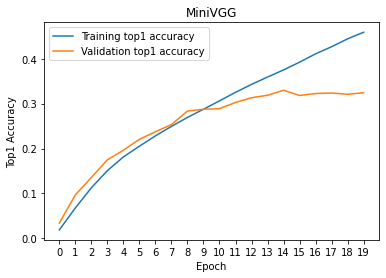

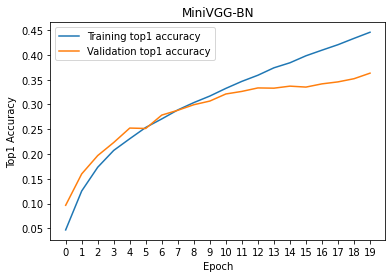

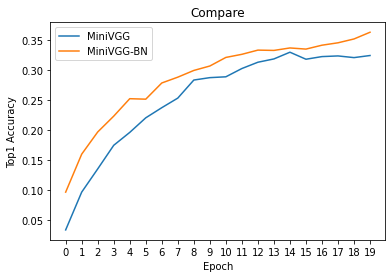

In [ ]:
x = np.arange(num_epochs)

# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, tr_his)
plt.plot(x, val_his)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, tr_his_BN)
plt.plot(x, val_his_BN)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()

# compare val accuracies of MiniVGG and MiniVGG-BN
plt.plot(x, val_his)
plt.plot(x, val_his_BN)
plt.legend(['MiniVGG', 'MiniVGG-BN'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Compare')
plt.show()

### TODO: __Summarize the effect of batch normalization:__

When batch normalization is applied to the neural network, it yields higher accuracy than the neural network that did not include batch normalization.

In [ ]:
pickle.dump(tr_his, open('tr_his.pkl', 'wb'))
pickle.dump(tr_his_BN, open('tr_his_BN.pkl', 'wb'))
pickle.dump(val_his, open('val_his.pkl', 'wb'))
pickle.dump(val_his_BN, open('val_his_BN.pkl', 'wb'))

## Step 5. Measure top1 and top5 accuracies of MiniVGG and MiniVGG-BN

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [ ]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values 
    of k.
    
    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the 
                network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.
    
    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [ ]:
##### To pass the test, both networks should have Top-5 accuracy above 55% #####
# vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
# vgg.load_state_dict(torch.load('./weights/MiniVGG.pth'))

test(vgg_BN, dataloaders['test'])
test(vgg, dataloaders['test'])

Top-1 accuracy 34.96%, Top-5 accuracy 64.94%
Top-1 accuracy 29.21%, Top-5 accuracy 58.62%


In [24]:
##### Download pretrained weights (TODO: remove for student version) #####

# !wget http://www.eecs.umich.edu/courses/eecs504/MiniVGG-BN.pth
# !wget http://www.eecs.umich.edu/courses/eecs504/MiniVGG.pth

# features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
# vgg_BN = VGG(features).to(device)

# features = make_layers(cfgs['MiniVGG'], batch_norm=False)
# vgg = VGG(features).to(device)

# vgg_BN.load_state_dict(torch.load('MiniVGG-BN.pth'))
# vgg.load_state_dict(torch.load('MiniVGG.pth'))

# test(vgg_BN, dataloaders['test'])
# test(vgg, dataloaders['test'])

# Convert Notebook to PDF


In [25]:
# generate pdf
# %%capture
!git clone https://gist.github.com/bc5f1add34fef7c7f9fb83d3783311e2.git
!cp bc5f1add34fef7c7f9fb83d3783311e2/colab_pdf.py colab_pdf.py
from colab_pdf import colab_pdf
# change the name to your ipynb file name shown on the top left of Colab window
# Important: make sure that your file name does not contain spaces!
colab_pdf('cktran_09859713.ipynb')

fatal: destination path 'bc5f1add34fef7c7f9fb83d3783311e2' already exists and is not an empty directory.
Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'

[Alternative, if the above cell doesn't work.](https://docs.google.com/document/d/1QTutnoApRow8cOxNrKK6ISEkA72QGfwLFXbIcpvarAI/edit?usp=sharing).